In [2]:
import itertools
import functools
from collections import Counter, defaultdict
import pandas
from matplotlib import pyplot as pl
import numpy as np
import gc
import math
training_fname = 'data/PrediqtTrainData.csv'
airports_fname = 'data/PrediqtAirports.csv'
testing_fname = 'data/PrediqtTestDataSmall.csv'

In [3]:
training_data = pandas.read_csv(training_fname, dtype={
    'PRICE': float, 
})

In [4]:
for item, itemtype in {
    'OUTBOUND_DATE': 'datetime64',  # can't believe you can't do this when parsing
    'INBOUND_DATE': 'datetime64',
    'SEARCH_DATEHOUR': 'datetime64[ns]',}.iteritems():
    print item
    training_data[item] = training_data[item].astype(itemtype)
gc.collect()

OUTBOUND_DATE
SEARCH_DATEHOUR
INBOUND_DATE


0

#Prices

In [5]:
training_data = training_data.sort_index(by='PRICE')

In [6]:
price_counts = training_data.PRICE.value_counts(sort=False)

In [7]:
num_prices = len(training_data.PRICE)
num_buckets = 150.
buckets = [0.]
running_total = 0
for price, count in price_counts.sort_index().iteritems():
    running_total += count
    if running_total >= num_prices / num_buckets:
        buckets.append(price)
        running_total = 0
buckets.append(price * 1.01)
print buckets
del price_counts

[0.0, 42.18, 54.600000000000001, 65.359999999999999, 75.280000000000001, 84.540000000000006, 93.620000000000005, 101.38, 109.23, 117.3, 124.98, 132.22, 139.58000000000001, 145.97999999999999, 151.97999999999999, 158.28999999999999, 163.84999999999999, 169.80000000000001, 174.24000000000001, 179.97999999999999, 185.36000000000001, 190.19, 195.62, 199.97999999999999, 204.97999999999999, 209.97999999999999, 215.34, 219.97999999999999, 225.08000000000001, 229.97999999999999, 235.36000000000001, 239.97999999999999, 245.40000000000001, 250.0, 256.05000000000001, 260.98000000000002, 268.86000000000001, 273.87, 279.98000000000002, 287.75999999999999, 294.49000000000001, 300.98000000000002, 309.98000000000002, 319.26999999999998, 326.98000000000002, 335.69, 343.48000000000002, 353.5, 362.98000000000002, 374.48000000000002, 385.13999999999999, 397.82999999999998, 409.98000000000002, 423.30000000000001, 437.98000000000002, 451.60000000000002, 466.51999999999998, 480.87, 496.33999999999997, 510.24

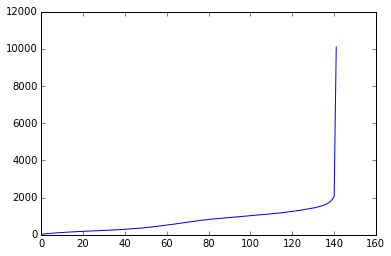

In [8]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot(buckets)
pl.show()

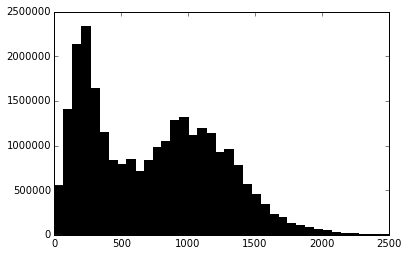

In [9]:
pl.hist(training_data.PRICE, num_buckets, color='black')
pl.xlim([0, 2500])
pl.show()

I think bucket_counts looks better than bin_counts.

In [10]:
print buckets

[0.0, 42.18, 54.600000000000001, 65.359999999999999, 75.280000000000001, 84.540000000000006, 93.620000000000005, 101.38, 109.23, 117.3, 124.98, 132.22, 139.58000000000001, 145.97999999999999, 151.97999999999999, 158.28999999999999, 163.84999999999999, 169.80000000000001, 174.24000000000001, 179.97999999999999, 185.36000000000001, 190.19, 195.62, 199.97999999999999, 204.97999999999999, 209.97999999999999, 215.34, 219.97999999999999, 225.08000000000001, 229.97999999999999, 235.36000000000001, 239.97999999999999, 245.40000000000001, 250.0, 256.05000000000001, 260.98000000000002, 268.86000000000001, 273.87, 279.98000000000002, 287.75999999999999, 294.49000000000001, 300.98000000000002, 309.98000000000002, 319.26999999999998, 326.98000000000002, 335.69, 343.48000000000002, 353.5, 362.98000000000002, 374.48000000000002, 385.13999999999999, 397.82999999999998, 409.98000000000002, 423.30000000000001, 437.98000000000002, 451.60000000000002, 466.51999999999998, 480.87, 496.33999999999997, 510.24

In [11]:
len(buckets)

142

In [12]:
def convert(num, buckets=buckets, bucket_ranges=None):
    """go from 0..1 to larger"""
    buckets = tuple(buckets)
    if bucket_ranges is None:
        bucket_ranges = itertools.izip(buckets, buckets[1:])
    step = 1 / float(len(buckets))
    cumsum = 0
    for low, high in bucket_ranges:
        if cumsum <= num < cumsum + step:
            t = (num - cumsum) / step
            return (1 - t) * low + t * high
        cumsum += step
    t = (num - (cumsum - step)) / step
    return (1 - t) * low + t * high

def reverse_convert(num, buckets, _range=range(12), cache={}):
    """go from larger to 0..1"""
    buckets = tuple(buckets)
    key = (num, buckets)
    try:
        return cache[key]
    except KeyError:
        pass
    
    # Binary search, because I couldn't spend time to figure it out properly... oh well
    bucket_ranges = zip(buckets, buckets[1:])
    high, low = 0., 1.
    for __ in _range:
        mid = (high + low) / 2.
        result = convert(mid, buckets=buckets, bucket_ranges=bucket_ranges)
        if abs(result - num) < 0.001:
            break
        if result > num:
            low = mid
        else:
            high = mid
            
    cache[key] = mid
    return mid

In [13]:
print convert(.992)
print convert(.9925)
print convert(.993)
print convert(.9935)

9005.4656576
9576.792604
10148.1195504
10719.4464968


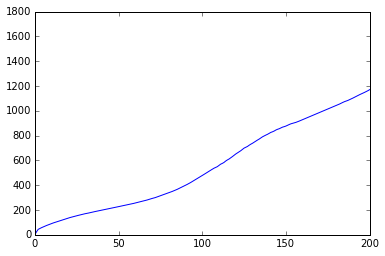

In [14]:
%matplotlib inline
pl.plot([convert(i / 250.) for i in xrange(250)])
pl.xlim([0, 200])
pl.ylim([0, 1800])
pl.show()

In [15]:
training_data.describe()

,PRICE
count,26454134.000000
mean,742.861342
std,508.558478
min,0.010000
25%,271.790000
50%,729.980000
75%,1109.980000
max,9999.840000


#Timedeltas

In [16]:
training_data['SEARCH_TO_OUTBOUND'] = training_data.OUTBOUND_DATE - training_data.SEARCH_DATEHOUR

In [17]:
training_data['SEARCH_TO_INBOUND'] = training_data.INBOUND_DATE - training_data.SEARCH_DATEHOUR

In [18]:
del training_data['SEARCH_DATEHOUR']

In [19]:
training_data['OUTBOUND_TO_INBOUND'] = training_data.INBOUND_DATE - training_data.OUTBOUND_DATE

In [20]:
one_day = 1000000000 * 60 * 60 * 24
oti_days = training_data.OUTBOUND_TO_INBOUND.map(lambda x: x.item() / one_day)

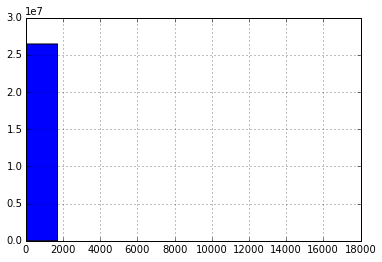

In [21]:
oti_days.hist()

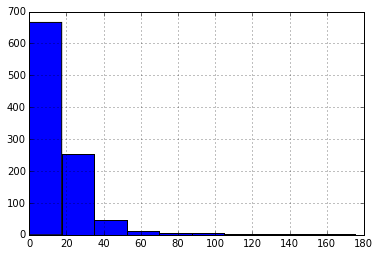

In [22]:
oti_days.sample(1000).hist()

In [23]:
oti_out, oti_bins = pandas.qcut(oti_days, 10, retbins=True)
oti_bins[-1] = int(oti_bins[-1] * 1.01)

In [24]:
oti_bins

array([  0.00000000e+00,   3.00000000e+00,   4.00000000e+00,
         7.00000000e+00,   9.00000000e+00,   1.20000000e+01,
         1.50000000e+01,   1.90000000e+01,   2.40000000e+01,
         3.30000000e+01,   1.71990000e+04])

In [25]:
oti_out.sample(500).value_counts(sort=False)

[0, 3]         77
(3, 4]         24
(4, 7]         82
(7, 9]         24
(9, 12]        40
(12, 15]       62
(15, 19]       48
(19, 24]       53
(24, 33]       44
(33, 17029]    46
dtype: int64

In [26]:
convert(0.5, oti_bins)

13.499999999999998

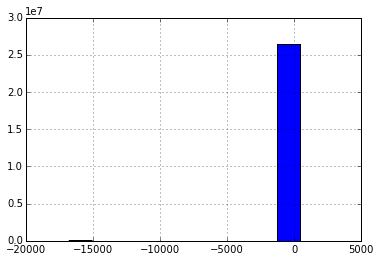

In [27]:
one_day = 1000000000 * 60 * 60 * 24
sto_days = training_data.SEARCH_TO_OUTBOUND.map(lambda x: x.item() / one_day)
sto_days.hist()

In [28]:
sto_out, sto_bins = pandas.qcut(sto_days, 10, retbins=True)
sto_bins[-1] = int(sto_bins[-1] * 1.01)
sto_bins

array([ -1.68070000e+04,   1.50000000e+01,   2.90000000e+01,
         4.30000000e+01,   6.10000000e+01,   8.10000000e+01,
         1.12000000e+02,   1.46000000e+02,   1.80000000e+02,
         2.15000000e+02,   4.37000000e+02])

In [30]:
sti_days = training_data.SEARCH_TO_INBOUND.map(lambda x: x.item() / one_day)
sti_out, sti_bins = pandas.qcut(sti_days, 10, retbins=True)
sti_bins[-1] = int(sti_bins[-1] * 1.01)
print sti_bins
reverse_convert_sti = functools.partial(reverse_convert, buckets=sti_bins)
#training_data['SEARCH_TO_INBOUND'] = sti_days.apply(reverse_convert_sti)
gc.collect()

[  -2.   27.   43.   60.   79.   99.  131.  166.  202.  235.  451.]


31457

In [31]:
training_data.describe()

,PRICE,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND
count,26454134.000000,26454134,26454134,26454134
mean,742.861342,-1 days +23:58:04.083478,-1 days +23:55:37.707836,-1 days +23:57:33.624358
std,508.558478,77 days 02:04:07.188880,79 days 12:17:05.539436,21 days 20:34:48.661853
min,0.010000,-16807 days +20:00:00,-2 days +21:00:00,0 days 00:00:00
25%,271.790000,35 days 10:00:00,51 days 20:00:00,6 days 00:00:00
50%,729.980000,81 days 03:00:00,99 days 12:00:00,12 days 00:00:00
75%,1109.980000,163 days 23:00:00,184 days 14:00:00,21 days 00:00:00
max,9999.840000,433 days 02:00:00,447 days 02:00:00,17029 days 00:00:00


#Airports data

In [32]:
airports_data = pandas.read_csv(airports_fname)

In [33]:
training_merged = pandas.merge(training_data, airports_data, left_on='ORIGIN', right_on='AIRPORT')
del training_data

In [34]:
for key in ('AIRPORT', 'CITY', 'CONTINENT'):
    del training_merged[key]
training_merged.head()

,ORIGIN,DESTINATION,OUTBOUND_DATE,INBOUND_DATE,PRICE,MARKETS,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,COUNTRY,LATITUDE,LONGITUDE,TRAFFIC
0,CGN,BGY,2016-03-25,2016-03-27,0.01,DE,80 days 01:00:00,82 days 01:00:00,2 days,DE,50.865833,7.141944,1457815
1,CGN,BGY,2016-01-12,2016-01-13,15.82,IT,6 days 07:00:00,7 days 07:00:00,1 days,DE,50.865833,7.141944,1457815
2,CGN,BGY,2016-01-22,2016-01-25,15.82,IT,16 days 13:00:00,19 days 13:00:00,3 days,DE,50.865833,7.141944,1457815
3,CGN,BGY,2016-01-28,2016-02-01,15.82,IT,19 days 16:00:00,23 days 16:00:00,4 days,DE,50.865833,7.141944,1457815
4,CGN,SXF,2016-01-19,2016-01-22,15.96,ES,13 days 07:00:00,16 days 07:00:00,3 days,DE,50.865833,7.141944,1457815


In [35]:
for key in ('COUNTRY', 'LATITUDE', 'LONGITUDE', 'TRAFFIC'):
    training_merged['ORIGIN_' + key] = training_merged[key]
    del training_merged[key]

In [36]:
training_merged = pandas.merge(training_merged, airports_data, left_on='DESTINATION', right_on='AIRPORT')
for key in ('AIRPORT', 'CITY', 'CONTINENT'):
    del training_merged[key]
for key in ('COUNTRY', 'LATITUDE', 'LONGITUDE', 'TRAFFIC'):
    training_merged['DESTINATION_' + key] = training_merged[key]
    del training_merged[key]
training_merged.head()

,ORIGIN,DESTINATION,OUTBOUND_DATE,INBOUND_DATE,PRICE,MARKETS,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_TRAFFIC,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_TRAFFIC
0,CGN,BGY,2016-03-25,2016-03-27,0.01,DE,80 days 01:00:00,82 days 01:00:00,2 days,DE,50.865833,7.141944,1457815,IT,45.668333,9.700278,2175706
1,CGN,BGY,2016-01-12,2016-01-13,15.82,IT,6 days 07:00:00,7 days 07:00:00,1 days,DE,50.865833,7.141944,1457815,IT,45.668333,9.700278,2175706
2,CGN,BGY,2016-01-22,2016-01-25,15.82,IT,16 days 13:00:00,19 days 13:00:00,3 days,DE,50.865833,7.141944,1457815,IT,45.668333,9.700278,2175706
3,CGN,BGY,2016-01-28,2016-02-01,15.82,IT,19 days 16:00:00,23 days 16:00:00,4 days,DE,50.865833,7.141944,1457815,IT,45.668333,9.700278,2175706
4,CGN,BGY,2016-01-24,2016-01-25,15.98,IT,15 days 09:00:00,16 days 09:00:00,1 days,DE,50.865833,7.141944,1457815,IT,45.668333,9.700278,2175706


In [37]:
#training_merged = training_merged.sort('PRICE')
del airports_data
gc.collect()

244

In [38]:
#for key in (
#    'ORIGIN', 'DESTINATION', 'ORIGIN_CITY', 'ORIGIN_COUNTRY', 
#    'ORIGIN_CONTINENT', 'DESTINATION_CITY', 'DESTINATION_COUNTRY', 
#    'DESTINATION_CONTINENT',
#):
#    training_merged[key] = training_merged[key].astype('category')
#training_merged.head()

#Categorical data (one-hot encodings)

##Markets

In [39]:
market_counts = Counter(
    market
    for __, marketlist in 
    training_merged.MARKETS.iteritems()
    for market in
    marketlist.split(';')
)
print market_counts.most_common(10)

[('**', 18219716), ('UK', 2579553), ('US', 1127899), ('FR', 801495), ('IT', 799988), ('DE', 771715), ('ES', 753441), ('SK', 557629), ('TR', 537822), ('AT', 522223)]


In [40]:
len(market_counts)

248

In [41]:
most_common_markets = [market for market, __ in market_counts.most_common(99)]
print most_common_markets

['**', 'UK', 'US', 'FR', 'IT', 'DE', 'ES', 'SK', 'TR', 'AT', 'PT', 'PL', 'RU', 'IE', 'HU', 'CZ', 'GR', 'BR', 'BG', 'NL', 'RO', 'CH', 'TW', 'HK', 'MT', 'IL', 'BE', 'SA', 'CA', 'KW', 'MO', 'SI', 'QA', 'KZ', 'BH', 'OM', 'IS', 'BY', 'GE', 'ME', 'MD', 'LB', 'AZ', 'AD', 'SM', 'VA', 'HR', 'LI', 'BA', 'GL', 'FO', 'MK', 'KO', 'BV', 'MN', 'LU', 'WF', 'TF', 'BN', 'WS', 'GU', 'PW', 'PG', 'PN', 'SB', 'MP', 'FJ', 'FM', 'VU', 'NU', 'CK', 'CC', 'CX', 'KH', 'TV', 'TO', 'TL', 'TK', 'AS', 'LK', 'MV', 'BT', 'BQ', 'GS', 'HM', 'MH', 'UM', 'MS', 'NF', 'CW', 'SX', 'KI', 'SJ', 'LA', 'AN', 'AQ', 'IO', 'MC', 'RS']


In [42]:
training_merged.MARKETS.tail(2)

26454132    **
26454133    **
Name: MARKETS, dtype: object

In [43]:
import gc
gc.collect()

9

In [44]:
training_merged.MARKETS.head()

0    DE
1    IT
2    IT
3    IT
4    IT
Name: MARKETS, dtype: object

In [45]:
training_merged.dtypes

ORIGIN                            object
DESTINATION                       object
OUTBOUND_DATE             datetime64[ns]
INBOUND_DATE              datetime64[ns]
PRICE                            float64
MARKETS                           object
SEARCH_TO_OUTBOUND       timedelta64[ns]
SEARCH_TO_INBOUND        timedelta64[ns]
OUTBOUND_TO_INBOUND      timedelta64[ns]
ORIGIN_COUNTRY                    object
ORIGIN_LATITUDE                  float64
ORIGIN_LONGITUDE                 float64
ORIGIN_TRAFFIC                     int64
DESTINATION_COUNTRY               object
DESTINATION_LATITUDE             float64
DESTINATION_LONGITUDE            float64
DESTINATION_TRAFFIC                int64
dtype: object

##Other

In [46]:
def make_onehot(df, field, size):
    series = df[field]
    counts = Counter(series)
    print len(counts)
    most_common = [item for item, __ in counts.most_common(size)]
    print most_common
    most_common_set = frozenset(most_common)
    excluded = sum(place not in most_common_set for place in series) / float(len(series))
    print excluded
    zeros_size = len(most_common) + (1 if excluded > 0 else 0)
    onehots = np.zeros((len(series), zeros_size), dtype='bool')
    most_common_index = most_common.index
    for i, (item, onehot) in enumerate(itertools.izip(series, onehots)):
        try:
            onehot[most_common_index(item)] = True
        except ValueError:
            onehot[zeros_size - 1] = True
        if not i % 1000000:
            print i
    df[field] = list(onehots)
    return df

In [47]:
pairs = {
    'ORIGIN': 149,
    'ORIGIN_COUNTRY': 24,
    'DESTINATION': 224,
    'DESTINATION_COUNTRY': 49,
}
for field, size in pairs.iteritems():
    print field
    gc_collect_1 = gc.collect()
    #training_merged = make_onehot(training_merged, field, size)
    print gc.collect() + gc_collect_1

ORIGIN
9
DESTINATION_COUNTRY
0
ORIGIN_COUNTRY
0
DESTINATION
0


In [48]:
gc.collect()

0

Doesn't seem like we need to rescale traffics based on distributions

In [49]:
training_merged.head()

,ORIGIN,DESTINATION,OUTBOUND_DATE,INBOUND_DATE,PRICE,MARKETS,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_TRAFFIC,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_TRAFFIC
0,CGN,BGY,2016-03-25,2016-03-27,0.01,DE,80 days 01:00:00,82 days 01:00:00,2 days,DE,50.865833,7.141944,1457815,IT,45.668333,9.700278,2175706
1,CGN,BGY,2016-01-12,2016-01-13,15.82,IT,6 days 07:00:00,7 days 07:00:00,1 days,DE,50.865833,7.141944,1457815,IT,45.668333,9.700278,2175706
2,CGN,BGY,2016-01-22,2016-01-25,15.82,IT,16 days 13:00:00,19 days 13:00:00,3 days,DE,50.865833,7.141944,1457815,IT,45.668333,9.700278,2175706
3,CGN,BGY,2016-01-28,2016-02-01,15.82,IT,19 days 16:00:00,23 days 16:00:00,4 days,DE,50.865833,7.141944,1457815,IT,45.668333,9.700278,2175706
4,CGN,BGY,2016-01-24,2016-01-25,15.98,IT,15 days 09:00:00,16 days 09:00:00,1 days,DE,50.865833,7.141944,1457815,IT,45.668333,9.700278,2175706


#Traffic

In [50]:
o_traffic = sorted(training_merged.ORIGIN_TRAFFIC)
o_traffic[0], o_traffic[-1]

(1, 17262579)

In [51]:
d_traffic = sorted(training_merged.DESTINATION_TRAFFIC)
d_traffic[0], d_traffic[-1]

(1, 17262579)

In [52]:
traffic_max = int(max(o_traffic[-1], d_traffic[-1]) * 1.01)
traffic_max

17435204

In [53]:
training_merged['ORIGIN_TRAFFIC'] = training_merged.ORIGIN_TRAFFIC / traffic_max
training_merged['DESTINATION_TRAFFIC'] = training_merged.DESTINATION_TRAFFIC / traffic_max

In [54]:
training_merged.ORIGIN_TRAFFIC.describe()

count    2.645413e+07
mean     3.193302e-01
std      2.996487e-01
min      5.735522e-08
25%      8.425792e-02
50%      2.262477e-01
75%      5.086684e-01
max      9.900991e-01
Name: ORIGIN_TRAFFIC, dtype: float64

Exception KeyboardInterrupt in <function remove at 0x000000001FB86198> ignored


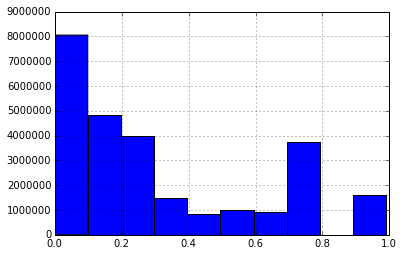

In [55]:
training_merged.ORIGIN_TRAFFIC.hist()

#Coordinates and distance

In [56]:
for key in ('ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'DESTINATION_LATITUDE', 'DESTINATION_LONGITUDE'):
    print key
    training_merged[key] = training_merged[key].apply(math.radians)
training_merged.describe()

ORIGIN_LATITUDE
ORIGIN_LONGITUDE
DESTINATION_LATITUDE
DESTINATION_LONGITUDE


,PRICE,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_TRAFFIC,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_TRAFFIC
count,26454134.000000,26454134,26454134,26454134,26454134.000000,26454134.000000,2.645413e+07,26454134.000000,26454134.000000,2.645413e+07
mean,742.861342,-1 days +23:58:04.083478,-1 days +23:55:37.707836,-1 days +23:57:33.624358,0.749060,-0.092963,3.193302e-01,0.463252,-0.248672,1.648270e-01
std,508.558478,77 days 02:04:07.188880,79 days 12:17:05.539436,21 days 20:34:48.661853,0.329074,0.699667,2.996487e-01,0.397045,1.095785,1.948394e-01
min,0.010000,-16807 days +20:00:00,-2 days +21:00:00,0 days 00:00:00,-0.957196,-3.074688,5.735522e-08,-0.957196,-3.139443,5.735522e-08
25%,271.790000,35 days 10:00:00,51 days 20:00:00,6 days 00:00:00,0.720869,-0.039735,8.425792e-02,0.321650,-1.294540,3.501674e-02
50%,729.980000,81 days 03:00:00,99 days 12:00:00,12 days 00:00:00,0.873343,0.004072,2.262477e-01,0.590227,-0.039735,8.762324e-02
75%,1109.980000,163 days 23:00:00,184 days 14:00:00,21 days 00:00:00,0.915479,0.161928,5.086684e-01,0.720869,0.335685,2.262477e-01
max,9999.840000,433 days 02:00:00,447 days 02:00:00,17029 days 00:00:00,1.498074,3.116285,9.900991e-01,1.498074,3.130151,9.900991e-01


In [59]:
gc.collect()

0

In [60]:
#for key in 'ORIGIN_LATITUDE ORIGIN_LONGITUDE DESTINATION_LATITUDE DESTINATION_LONGITUDE DISTANCE'.split():
for key in 'ORIGIN_LATITUDE ORIGIN_LONGITUDE DESTINATION_LATITUDE DESTINATION_LONGITUDE'.split():
    print key
    sorted_values = sorted(training_merged[key])
    minimum, maximum = sorted_values[0] * 1.01, sorted_values[-1] * 1.01
    print minimum, maximum
    #training_merged[key] = (training_merged[key] - minimum) / (maximum - minimum)
    print gc.collect()

ORIGIN_LATITUDE
-0.966767766679 1.51305442978
0
ORIGIN_LONGITUDE
-3.10543525513 3.14744823323
0
DESTINATION_LATITUDE
-0.966767766679 1.51305442978
0
DESTINATION_LONGITUDE
-3.17083736087 3.16145255339
0


In [61]:
#for key in ('DISTANCE',):
#    print key
#    sorted_values = sorted(training_merged[key])
#    minimum, maximum = sorted_values[0] * 1.01, sorted_values[-1] * 1.01
#    print minimum, maximum
#    training_merged[key] = (training_merged[key] - minimum) / (maximum - minimum)
#    print gc.collect()

In [62]:
def onehot_encode_date(date):
    array = np.zeros((7 + 12 + 31,), dtype='bool')
    array[date.weekday() - 1] = True
    array[date.month + 7 - 1] = True
    array[date.day + 7 + 12 - 1] = True
    return array

In [63]:
#training_merged.sample(5).OUTBOUND_DATE.apply(onehot_encode_date)

In [64]:
training_merged.head()

,ORIGIN,DESTINATION,OUTBOUND_DATE,INBOUND_DATE,PRICE,MARKETS,SEARCH_TO_OUTBOUND,SEARCH_TO_INBOUND,OUTBOUND_TO_INBOUND,ORIGIN_COUNTRY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_TRAFFIC,DESTINATION_COUNTRY,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_TRAFFIC
0,CGN,BGY,2016-03-25,2016-03-27,0.01,DE,80 days 01:00:00,82 days 01:00:00,2 days,DE,0.887776,0.12465,0.083613,IT,0.797063,0.169302,0.124788
1,CGN,BGY,2016-01-12,2016-01-13,15.82,IT,6 days 07:00:00,7 days 07:00:00,1 days,DE,0.887776,0.12465,0.083613,IT,0.797063,0.169302,0.124788
2,CGN,BGY,2016-01-22,2016-01-25,15.82,IT,16 days 13:00:00,19 days 13:00:00,3 days,DE,0.887776,0.12465,0.083613,IT,0.797063,0.169302,0.124788
3,CGN,BGY,2016-01-28,2016-02-01,15.82,IT,19 days 16:00:00,23 days 16:00:00,4 days,DE,0.887776,0.12465,0.083613,IT,0.797063,0.169302,0.124788
4,CGN,BGY,2016-01-24,2016-01-25,15.98,IT,15 days 09:00:00,16 days 09:00:00,1 days,DE,0.887776,0.12465,0.083613,IT,0.797063,0.169302,0.124788


In [65]:
# TODO: delete all other rows and then calculate distances
for col in 'ORIGIN_TRAFFIC DESTINATION_TRAFFIC PRICE ORIGIN DESTINATION ORIGIN_COUNTRY DESTINATION_COUNTRY MARKETS SEARCH_TO_OUTBOUND SEARCH_TO_INBOUND OUTBOUND_TO_INBOUND'.split():
    try:
        print col
        del training_merged[col]
    except Exception as e:
        print repr(e)
        pass
gc.collect()

ORIGIN_TRAFFIC
DESTINATION_TRAFFIC
PRICE
ORIGIN
DESTINATION
ORIGIN_COUNTRY
DESTINATION_COUNTRY
MARKETS
SEARCH_TO_OUTBOUND
SEARCH_TO_INBOUND
OUTBOUND_TO_INBOUND


274

In [66]:
training_merged['DISTANCE'] = training_merged.apply(distance, axis=1)
training_merged.DISTANCE.describe()

Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


KeyboardInterrupt: 

In [69]:
training_merged.head()

,OUTBOUND_DATE,INBOUND_DATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,2016-03-25,2016-03-27,0.887776,0.12465,0.797063,0.169302
1,2016-01-12,2016-01-13,0.887776,0.12465,0.797063,0.169302
2,2016-01-22,2016-01-25,0.887776,0.12465,0.797063,0.169302
3,2016-01-28,2016-02-01,0.887776,0.12465,0.797063,0.169302
4,2016-01-24,2016-01-25,0.887776,0.12465,0.797063,0.169302


In [70]:
del training_merged['OUTBOUND_DATE']
del training_merged['INBOUND_DATE']
gc.collect()

585

In [74]:
training_merged.to_csv('my_data/latlong.csv')

In [75]:
print "DONE!"

DONE!


In [76]:
del training_merged

In [78]:
import pandas
import math
import gc
training_latlong = pandas.read_csv('my_data/latlong.csv')

In [79]:
gc.collect()
sin, cos, acos = math.sin, math.cos, math.acos
def distance(row):
    lat1 = row['ORIGIN_LATITUDE']
    lon1 = row['ORIGIN_LONGITUDE']
    lat2 = row['DESTINATION_LATITUDE']
    lon2 = row['DESTINATION_LONGITUDE']
    
    delta_lambda = lon2 - lon1
    
    return acos(
        sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(delta_lambda)
    ) * 6371

In [80]:
for key in ('DISTANCE',):
    print key
    sorted_values = sorted(training_latlong.apply(distance, axis=1))
    minimum, maximum = sorted_values[0] * 1.01, sorted_values[-1] * 1.01
    print minimum, maximum
    #training_merged[key] = (training_merged[key] - minimum) / (maximum - minimum)
    print gc.collect()

DISTANCE
0.0 20141.4607366
0
